In [1]:
import pandas as pd

df=pd.read_csv('incident_event_log.csv')
df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [2]:
# Information about the dataset
print(df.shape)
print("columns: ",df.columns)

(141712, 36)
columns:  Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')


In [3]:
# priorite prediction
# (1=high,2=medium,3=low)

df['priority'].value_counts(dropna=False)

priority
3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Critical      2258
Name: count, dtype: int64

In [4]:
# selecting only relevant columns
df_filtered=df[["incident_state","impact","urgency","priority","contact_type","category","subcategory","opened_at","resolved_at"]].copy()


# drop rows with missing priority if any
df_filtered.dropna(subset=['priority'], inplace=True)

# convert priority into readable labels

priority_map = {
    '1 - Critical': 'High',
    '2 - High': 'High',
    '3 - Moderate': 'Medium',
    '4 - Low': 'Low'
}
df_filtered['priority_label']=df_filtered['priority'].map(priority_map)



Synthesize incident_text

Since this dataset doesn't have textual descriptions, we’ll generate synthetic ones based on categorical fields — this enables NLP modeling.

This allows us to apply text vectorization (TF-IDF) later
Real-world projects often need synthetic augmentation

In [5]:
def generate_incident_text(row):
    return f"A {row['category']} - {row['subcategory']} issue was reported via {row['contact_type']} with {row['impact']} impact and {row['urgency']} urgency."

df_filtered['incident_text'] = df_filtered.apply(generate_incident_text, axis=1)


In [6]:
print(df_filtered[['incident_text', 'priority_label']].head())
print("Final dataset shape:", df_filtered.shape)


                                       incident_text priority_label
0  A Category 55 - Subcategory 170 issue was repo...         Medium
1  A Category 55 - Subcategory 170 issue was repo...         Medium
2  A Category 55 - Subcategory 170 issue was repo...         Medium
3  A Category 55 - Subcategory 170 issue was repo...         Medium
4  A Category 40 - Subcategory 215 issue was repo...         Medium
Final dataset shape: (141712, 11)


Phase-1 Output

| Item             | Description                           |
| ---------------- | ------------------------------------- |
| `df_filtered`    | Cleaned dataset with key features     |
| `priority_label` | Our target variable (High/Medium/Low) |
| `incident_text`  | Synthesized field for NLP             |
| Missing values   | Handled                               |
| Class imbalance  | Observed in `value_counts()`          |


EDA

C:\Users\rahul\AppData\Local\Temp\ipykernel_18388\2936675443.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='priority', palette='viridis',


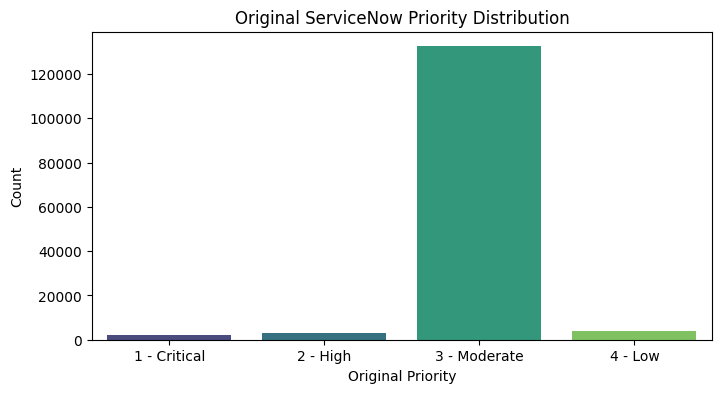

In [7]:
# visualization

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='priority', palette='viridis',
order=['1 - Critical', '2 - High', '3 - Moderate', '4 - Low'])
plt.title("Original ServiceNow Priority Distribution")
plt.xlabel("Original Priority")
plt.ylabel("Count")
plt.show()


In [8]:
# Cleaning text for NLP

import re

def generate_incident_text(row):
    return f"A {row['category']} - {row['subcategory']} issue was reported via {row['contact_type']} with {row['impact']} impact and {row['urgency']} urgency."

df['incident_text'] = df.apply(generate_incident_text, axis=1)


def clean_text(text):
    text=text.lower()
    text=re.sub(r"[^a-zA-Z0-9\s]","",text) # removes punctuation
    text=re.sub(r"\s+"," ",text).strip() #normalize whitespace
    return text

df['cleaned_text']=df['incident_text'].apply(clean_text)

In [9]:
# most common words in incident text

from collections import Counter

# Tokenize all words
all_words=" ".join(df['cleaned_text']).split()
common_words=Counter(all_words).most_common(10)

# top 10
print("Top 10 most common words in incident text: ")
for word, count in common_words:
    print(f"{word}: {count}")

Top 10 most common words in incident text: 
2: 268513
medium: 268429
a: 141712
issue: 141712
was: 141712
reported: 141712
via: 141712
with: 141712
impact: 141712
and: 141712


In [10]:
priority_map = {
    '1 - Critical': 'High',
    '2 - High': 'High',
    '3 - Moderate': 'Medium',
    '4 - Low': 'Low'
}

df['priority_label'] = df['priority'].map(priority_map)

print(df[['cleaned_text', 'priority_label']].sample(5))

                                             cleaned_text priority_label
22893   a category 46 subcategory 150 issue was report...         Medium
26308   a category 26 subcategory 175 issue was report...         Medium
39290   a category 19 subcategory 163 issue was report...           High
138306  a category 26 subcategory 175 issue was report...         Medium
107856  a category 32 subcategory 9 issue was reported...         Medium


In [11]:
print(df.columns)


Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'incident_text', 'cleaned_text', 'priority_label'],
      dtype='object')


Phase-2 Output

| Output                | Description                          |
| --------------------- | ------------------------------------ |
| `priority_label`      | Clean labels (High, Medium, Low)     |
| `incident_text`       | Synthesized from categorical columns |
| `cleaned_text`        | Preprocessed version for NLP         |
| `priority_label` plot | Visual check for class imbalance     |


Feature Engineering and Vectorization

In [12]:
# encoding the target variable

from sklearn.preprocessing import LabelEncoder

# encode the labels (high=0, medium=1, low=2, or similar)
le=LabelEncoder()
df['priority_encoded']=le.fit_transform(df['priority_label'])

# class mapping
label_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
print("Label Mapping: ",label_mapping)

Label Mapping:  {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


Machine learning models can’t work directly with text labels like "High" or "Email" — they need numerical input.

One-hot encoding is the most common way to handle this: it converts each category into a binary (0/1) vector.

In [13]:
# One-Hot encode 
# we'll encode columns like impact, urgency, contact_type

structured_cols=['impact','urgency','contact_type','incident_state','category','subcategory']

# apply one-hot encoding using pd.get_dummies()
df_structured=pd.get_dummies(df[structured_cols], drop_first=True)

# get_dummies() --> Transforms each categorical column into multiple binary (0/1) columns — one for each category.

print("Structured Feature Shape:", df_structured.shape)




Structured Feature Shape: (141712, 328)


In [14]:
# using TF-IDF Vectorization for cleaned text
# converts clean text into numerical

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_features=1000,stop_words='english')

X_test=tfidf.fit_transform(df['cleaned_text'])
print("TF-IDF Shape: ",X_test.shape)

TF-IDF Shape:  (141712, 276)


In [ ]:
from scipy.sparse import hstack

# X_text=TF-IDF matrix
# df_structured = one-hot encoded dataframe
X_final=hstack([X_test,df_structured])
print("Structured Feature Shape:", df_structured.shape)

# final target variable
y_final=df['priority_encoded']

Structured Feature Shape: (141712, 328)


Phase-3 Summary

| Step                      | Description                          |
| ------------------------- | ------------------------------------ |
| Select structured columns | Categorical, non-text columns        |
| Use `pd.get_dummies()`    | Convert them into binary 0/1 columns |
| Use `drop_first=True`     | Avoid dummy variable trap            |
| Combine later with TF-IDF | For full feature matrix              |


In [16]:
# train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.2,random_state=42, stratify=y_final)

print("Train Shape: ", X_train.shape)
print("Test Shape: ", X_test.shape)

Train Shape:  (113369, 604)
Test Shape:  (28343, 604)


In [17]:
# train 
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

y_pred_lr=lr.predict(X_test)
print("Logistic Regression: ",y_pred_lr)

Logistic Regression:  [2 2 2 ... 2 2 2]


In [18]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

y_pred_rf= rf.predict(X_test)


In [19]:
# evaluation

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(name, y_test, y_pred):
    print(f"\nEvaluation for {name}")
    print("Accuracy: ",accuracy_score(y_test,y_pred))
    print(f"Classification Report for {name}: \n\n",classification_report(y_test,y_pred,target_names=le.classes_))
    print(f"Confusion Matrix for {name}: \n\n",confusion_matrix(y_test,y_pred))
    
# evaluate each model
evaluate_model("Logistic Regression",y_test,y_pred_lr)
evaluate_model("Random Forest",y_test,y_pred_rf)


Evaluation for Logistic Regression
Accuracy:  0.9998588716790742
Classification Report for Logistic Regression: 

               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1046
         Low       1.00      1.00      1.00       806
      Medium       1.00      1.00      1.00     26491

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343

Confusion Matrix for Logistic Regression: 

 [[ 1046     0     0]
 [    0   806     0]
 [    2     2 26487]]

Evaluation for Random Forest
Accuracy:  1.0
Classification Report for Random Forest: 

               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1046
         Low       1.00      1.00      1.00       806
      Medium       1.00      1.00      1.00     26491

    accuracy                           1.00     28343
   macro avg       1.00      1.00

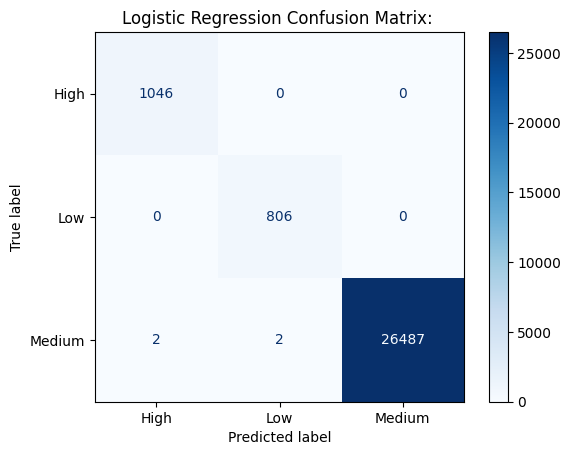

In [20]:
import seaborn as asns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    lr,X_test,y_test,display_labels=le.classes_,cmap='Blues',values_format='d'
)
plt.title("Logistic Regression Confusion Matrix: ")
plt.show()

Summary of Phase-4

| Output                   | Description                             |
| ------------------------ | --------------------------------------- |
| `y_pred_lr`, `y_pred_rf` | Predictions from models                 |
| `classification_report`  | Detailed precision, recall, F1          |
| `confusion_matrix`       | Visual insight into misclassifications  |
| Best Model Selected      | Ready for Phase 5: API or Streamlit app |


In [24]:
# saving the models

import joblib

joblib.dump(lr,'models/model.pkl')
joblib.dump(rf,'models/random_forest.pkl')
joblib.dump(tfidf,'models/vectorizer.pkl')
joblib.dump(le,'models/encoder.pkl')

# ✅ NEW: Save structured column names (for prediction time alignment)
joblib.dump(df_structured.columns.tolist(), "models/structured_columns.pkl")

# ✅ NEW: Save final number of features (TF-IDF + structured)
joblib.dump(X_train.shape[1], "models/feature_length.pkl")

['models/feature_length.pkl']